In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
#import tqdm.notebook as tqdm
from tqdm import tqdm


import numpy as np
from loguru import logger
logger.remove()

from pim.models import rate
from pim.models.weights import cpu1a_pontine_output, cpu1b_pontine_output, motor_output, pontine_output
from pim.models.weights.shift import motor_output_theoretical, W_CPU4_CPU1a, W_CPU4_CPU1b
from pim.models.constants import *
from pim.network import Network, RecurrentForwardNetwork, InputLayer, Layer, FunctionLayer, Output, WeightedSynapse

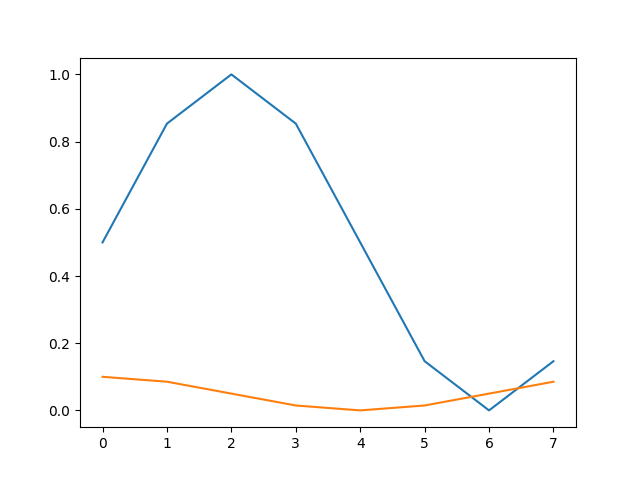

In [3]:
N_COLUMNS = 8
x = np.linspace(0, np.pi*2, N_COLUMNS, endpoint = False)


A = 0.1
d = -np.pi/2

head = np.maximum(0,0.5*np.cos(x + d)+0.5)
home = np.maximum(0,A*(0.5 * np.cos(x) + 0.5))

plt.plot(head)
plt.plot(home)

In [4]:
noise = 0.0
pfn_weight_factor = 1

def getNetwork(home, beta = 0.3):
    return RecurrentForwardNetwork({
        "flow": InputLayer(initial=np.zeros(2)),
        "heading": InputLayer(),
        "TB1": FunctionLayer(
            inputs = ["heading"],
            function = lambda i: 0.5 + 0.5 * np.cos(x + i[0]),
        ),
        "TN1": FunctionLayer(
            inputs = ["flow"],
            function = lambda i: np.array([0.,0.]),
            initial = np.zeros(N_TN1),
        ),
        "TN2": FunctionLayer(
            inputs = ["flow"],
            function = lambda i: np.array([0.4,0.4]),
            initial = np.zeros(N_TN2),
        ),
        "CPU4": rate.MemorylessCPU4Layer(
            "TB1", "TN1", "TN2",
            rate.W_TN_CPU4,
            rate.W_TB1_CPU4,
            gain = pfn_weight_factor,
            slope = cpu4_slope_tuned,
            bias = cpu4_bias_tuned,
            noise = noise,
            background_activity = beta,
        ),
        "memory": FunctionLayer(
            inputs = ["CPU4"],
            function = lambda i: i[0] * np.hstack([home,home]),
        ),
        "Pontine": FunctionLayer(
            inputs = ["memory"],
            function = pontine_output(noise),
            initial = np.zeros(N_Pontine)
        ),
#         "theory": FunctionLayer(
#             inputs = ["memory", "CPU4", "TB1", "Pontine"],
#             function = motor_output_theoretical(noise)
#         ),
        "CPU1a": FunctionLayer(
            inputs = [WeightedSynapse("CPU4", W_CPU4_CPU1a), "memory", "Pontine"],
            function = cpu1a_pontine_output(
                noise,
                cpu1_pontine_slope_tuned,
                cpu1_pontine_bias_tuned,
            ),
            initial = np.zeros(N_CPU1A),
        ),
        "CPU1b": FunctionLayer(
            inputs = [WeightedSynapse("CPU4", W_CPU4_CPU1b), "memory", "Pontine"],
            function = cpu1b_pontine_output(
                noise,
                cpu1_pontine_slope_tuned,
                cpu1_pontine_bias_tuned,
            ),
            initial = np.zeros(N_CPU1B),
        ),
        "motor": FunctionLayer(
            inputs = ["CPU1a", "CPU1b"],
            function = motor_output(noise),
        )
    })

In [5]:
amplitudes = np.arange(0,1,0.01)
betas = np.arange(0,0.6,0.01)
deltas = np.arange(-np.pi,np.pi,0.01)
results = []


for b in tqdm(betas):
    home = np.clip(0.2*(0.5 * np.cos(x) + 0.5) + 0.8,0,1)
    network = getNetwork(home,b)
    motors = []
    for delta in deltas:
        network.layers["flow"].set(0)
        network.layers["heading"].set(np.array([delta]))
        # Let ring attractor settle
        for i in range(10):
            network.step(1)
        #network.step(1)
        motor = network.output("motor")
        motors.append(motor)
        
    if b == 0:
        no_beta_motors = motors
        
    results.append(motors)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:51<00:00,  1.17it/s]


(-0.15, 0.15)

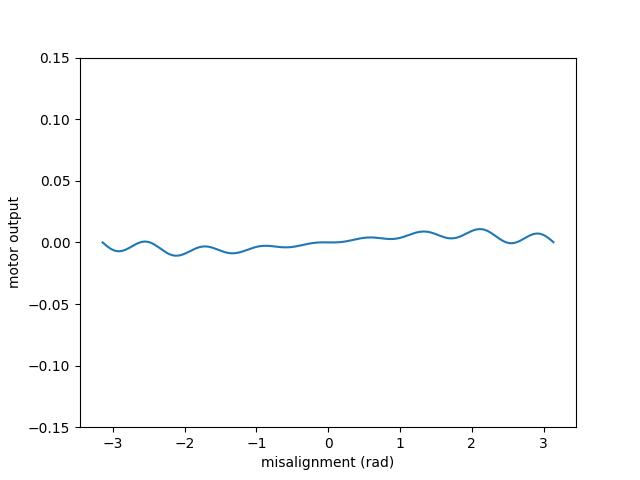

In [11]:
plt.figure() #figsize=(10,10))
#motors = 
plt.plot(deltas, no_beta_motors)
plt.xlabel("misalignment (rad)")
plt.ylabel("motor output")
#print(motors)
plt.ylim([-0.15,0.15])

Text(0.5, 0, 'motor output')

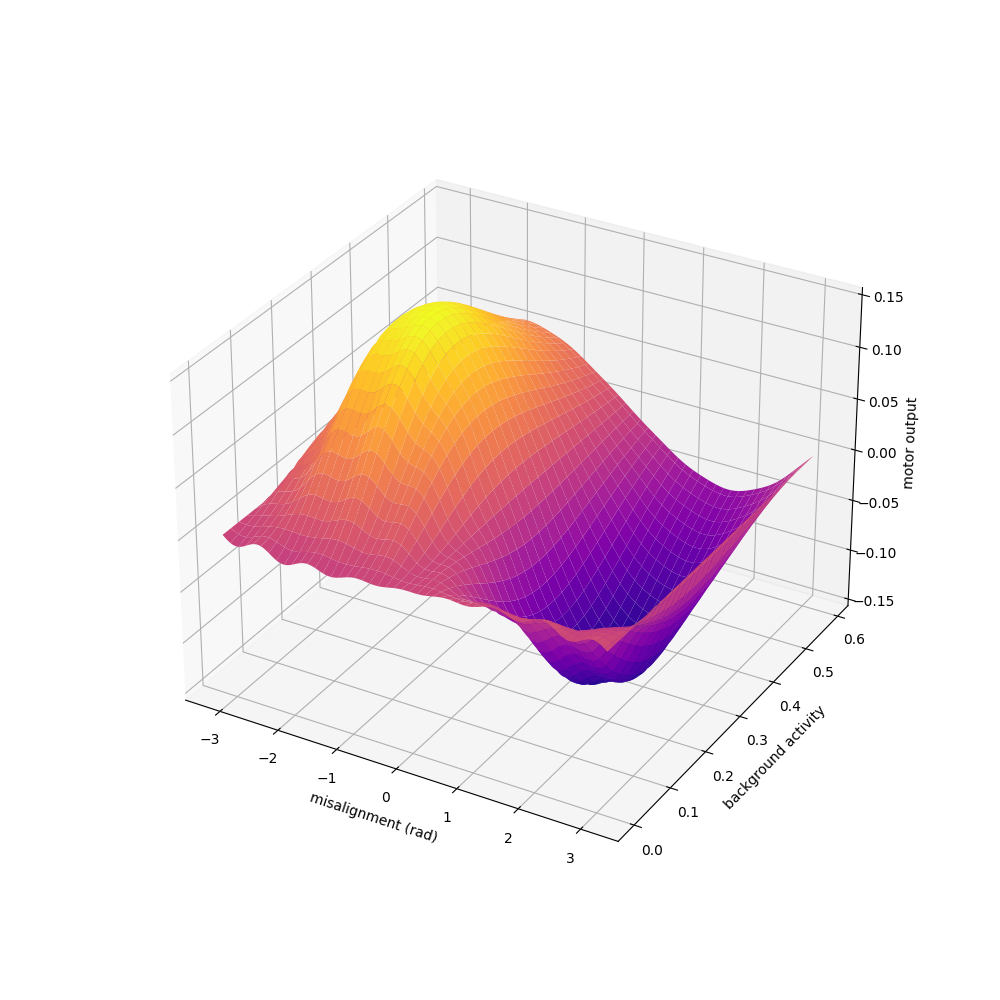

In [10]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

(x,y) = np.meshgrid(deltas,betas)
z = np.array(results)

ax.plot_surface(x,y,z,cmap='plasma')
ax.set_xlabel("misalignment (rad)")
ax.set_ylabel("background activity")
ax.set_zlabel("motor output")
# ax.view_init(0,-3)